In [160]:
import numpy
import xarray
import matplotlib
import matplotlib.pyplot as mp
import datetime
import matplotlib.colors
import matplotlib.cm
import scipy.stats
import itertools
import string
import matplotlib.patches
import astropy.convolution
import scipy.ndimage

import pandas

import matplotlib.ticker
import cartopy.mpl.gridliner #import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import mpl_toolkits
import cartopy

DEGREE_SIGN = u'\u00B0'
mp.rcParams.update({'mathtext.default': 'regular'})

% matplotlib inline

In [2]:
run_info = 'FMAASO'
skip_time=0

In [3]:
ens = '001'

In [4]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/400/'+ens+'/'
cont_mfds = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [5]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/1000/'+ens+'/'
phys_mfds = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-0[2,3,4,5,6,7,8,9]*')

In [172]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/400/'+ens+'/'
cont_mfds_day1 = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-01*')

In [173]:
data_dir = '/beegfs/DATA/pritchard/blangenb/WRF_ARCHIVE/CHEYENNE/nested_FMAASO_10days/1000/'+ens+'/'
phys_mfds_day1 = xarray.open_mfdataset(data_dir + 'wrfout_d03_1979-01-01*')

In [6]:
cont_time = cont_mfds['Times']

In [7]:
cont_qfx = cont_mfds['QFX']
phys_qfx = phys_mfds['QFX']

In [8]:
cont_rainnc = cont_mfds['RAINNC']
phys_rainnc = phys_mfds['RAINNC']

In [175]:
cont_rainnc_day1 = cont_mfds_day1['RAINNC']
phys_rainnc_day1 = phys_mfds_day1['RAINNC']

In [9]:
cont_qfx_time_mean = cont_qfx.mean(dim='Time')
phys_qfx_time_mean = phys_qfx.mean(dim='Time')

In [10]:
cont_rain_diffs = cont_rainnc.diff(dim='Time')#.values
phys_rain_diffs = phys_rainnc.diff(dim='Time')#.values

In [176]:
cont_rain_diffs_day1 = cont_rainnc_day1.diff(dim='Time')#.values
phys_rain_diffs_day1 = phys_rainnc_day1.diff(dim='Time')#.values

In [11]:
cont_rain_time_mean = cont_rain_diffs.mean(dim='Time')
phys_rain_time_mean = phys_rain_diffs.mean(dim='Time')#numpy.mean(phys_rain_diffs, axis=0)

In [177]:
cont_rain_time_mean_day1 = cont_rain_diffs_day1.mean(dim='Time')
phys_rain_time_mean_day1 = phys_rain_diffs_day1.mean(dim='Time')

In [12]:
rain_diffs_time_mean = phys_rain_time_mean.values-cont_rain_time_mean.values

In [178]:
rain_diffs_time_mean_day1 = phys_rain_time_mean_day1.values-cont_rain_time_mean_day1.values

# landmask

In [14]:
landmask = cont_mfds['LANDMASK'].values[0,:,:]

# lat,lon values

In [15]:
XLAT = cont_mfds['XLAT'].values[0,:,:]
XLONG = cont_mfds['XLONG'].values[0,:,:]

In [16]:
#cont_rain_time_mean_landmask = numpy.copy(cont_rain_time_mean.values)
#cont_rain_time_mean_landmask[landmask==0] = numpy.nan
#
#phys_rain_time_mean_landmask = numpy.copy(phys_rain_time_mean.values)
#phys_rain_time_mean_landmask[landmask==0] = numpy.nan

rain_diffs_time_mean_landmask = numpy.copy(rain_diffs_time_mean)
rain_diffs_time_mean_landmask[landmask==0] = numpy.nan

In [179]:
rain_diffs_time_mean_day1_landmask = numpy.copy(rain_diffs_time_mean_day1)
rain_diffs_time_mean_day1_landmask[landmask==0] = numpy.nan

In [18]:
rain_diffs_time_latmean = numpy.nanmean(rain_diffs_time_mean_landmask, axis=0)

In [180]:
rain_diffs_time_latmean_day1 = numpy.nanmean(rain_diffs_time_mean_day1_landmask, axis=0)

In [142]:
cmap_custom = matplotlib.colors.ListedColormap([matplotlib.cm.RdBu(0.1), \
                                                matplotlib.cm.RdBu(0.25), \
                                                #matplotlib.cm.RdBu(0.3), \
                                                #matplotlib.cm.RdBu(0.6), \
                                                matplotlib.cm.RdBu(0.6), \
                                                matplotlib.cm.RdBu(0.7)])
                                                
cmap_custom.set_over(matplotlib.cm.RdBu(.8))
cmap_custom.set_under(matplotlib.cm.RdBu(0))

bounds = numpy.array([-10,-5,0,5,10])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap_custom.N)

/export/home/blangenb/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


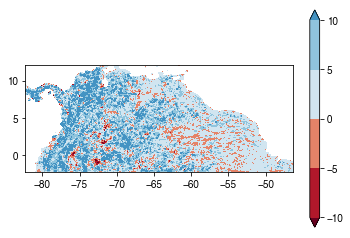

In [143]:
mp.contourf(XLONG,\
            XLAT,\
            rain_diffs_time_mean_landmask*24.,\
            levels=bounds,\
            cmap=cmap_custom,\
            extend='both',\
            norm=norm)
mp.colorbar()
ax = mp.axes()
ax.set_aspect('equal')

take rolling mean of longitudinally-averaged precip change

In [148]:
window=75

rain_diffs_time_latmean_rolling_mean = pandas.Series(rain_diffs_time_latmean*24.).rolling(window=75, \
                                                                                      center=True, \
                                                                                      min_periods=1).mean()
rain_diffs_time_latmean_rolling_std = pandas.Series(rain_diffs_time_latmean*24.).rolling(window=75, \
                                                                                     center=True, \
                                                                                     min_periods=1).std(ddof=1)


In [181]:
window=75

rain_diffs_time_latmean_day1_rolling_mean = pandas.Series(rain_diffs_time_latmean_day1*24.).rolling(window=75, \
                                                                                      center=True, \
                                                                                      min_periods=1).mean()
rain_diffs_time_latmean_day1_rolling_std = pandas.Series(rain_diffs_time_latmean_day1*24.).rolling(window=75, \
                                                                                     center=True, \
                                                                                     min_periods=1).std(ddof=1)


create custom colormap

In [154]:
cmap_custom = matplotlib.colors.ListedColormap([matplotlib.cm.BrBG(0.1), \
                                                matplotlib.cm.BrBG(0.25), \
                                                #matplotlib.cm.BrBG(0.3), \
                                                #matplotlib.cm.BrBG(0.6), \
                                                matplotlib.cm.BrBG(0.6), \
                                                matplotlib.cm.BrBG(0.7)])                      
cmap_custom.set_over(matplotlib.cm.BrBG(.8))
cmap_custom.set_under(matplotlib.cm.BrBG(0))
bounds = numpy.array([-10,-5,0,5,10])
norm = matplotlib.colors.BoundaryNorm(bounds, cmap_custom.N)

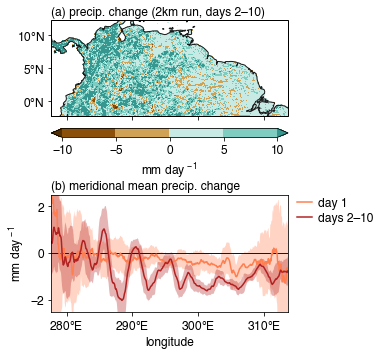

In [187]:
# fontsize = 12

map_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(4.25,5))

ax1 = fig.add_subplot(211, projection=map_proj)

contour_plot = ax1.contourf(XLONG+360.,\
                XLAT,\
                rain_diffs_time_mean_landmask*24.,\
                levels=bounds,\
                cmap=cmap_custom,\
                extend='both',\
                norm=norm)

ax1.text(s='(a) precip. change (2km run, days 2–10)', x=0, y=1.02,\
       transform=ax1.transAxes, ha='left', va='bottom', \
       fontsize=fontsize)
ax1.set_extent([XLONG.min(),XLONG.max(),XLAT.min(),XLAT.max()])
ax1.coastlines(resolution='50m', color='0.1')

ax1.set_xticks([-360+280,-360+290,-360+300,-360+310])
ax1.set_xticklabels(['','',''])
ax1.set_yticks([0,5,10])
ax1.set_yticklabels(['$0$'+DEGREE_SIGN+'N','$5$'+DEGREE_SIGN+'N','$10$'+DEGREE_SIGN+'N'])
ax1.tick_params(labelsize=fontsize)


ax2 = fig.add_subplot(212)

ax2.axhline(0, c='0.1', lw=1)
ax2.set_xlim(XLONG.min()+360.,XLONG.max()+360.)

ax2.plot(XLONG[0,:]+360.,\
        rain_diffs_time_latmean_day1_rolling_mean, \
        c='coral', label='day 1')
ax2.fill_between(XLONG[0,:]+360., \
                rain_diffs_time_latmean_day1_rolling_mean-rain_diffs_time_latmean_day1_rolling_std,\
                rain_diffs_time_latmean_day1_rolling_mean+rain_diffs_time_latmean_day1_rolling_std,\
                facecolor='coral', alpha=0.333)

ax2.plot(XLONG[0,:]+360.,\
        rain_diffs_time_latmean_rolling_mean, \
        c='firebrick', label='days 2–10')
ax2.fill_between(XLONG[0,:]+360., \
                rain_diffs_time_latmean_rolling_mean-rain_diffs_time_latmean_rolling_std,\
                rain_diffs_time_latmean_rolling_mean+rain_diffs_time_latmean_rolling_std,\
                facecolor='firebrick', alpha=0.333)

ax2.text(s='(b) meridional mean precip. change', x=0, y=1.02,\
       transform=ax2.transAxes, ha='left', va='bottom', \
       fontsize=fontsize)
ax2.tick_params(labelsize=fontsize)

ax2.set_xticks([280,290,300,310])
ax2.set_xticklabels(['$280$'+DEGREE_SIGN+'E','$290$'+DEGREE_SIGN+'E','$300$'+DEGREE_SIGN+'E','$310$'+DEGREE_SIGN+'E'])

ax2.set_xlabel('longitude', fontsize=fontsize)
ax2.set_ylabel('mm day$^{\,-1}$', fontsize=fontsize)

ax2.set_ylim(-2.5,2.5)

fig.tight_layout(h_pad=7.5)

axpos = ax1.get_position()
cbar_ax = fig.add_axes([axpos.x0, axpos.y0-0.03, axpos.width, 0.025])
#cbar_ax = fig.add_axes([axpos.x1+0.05, axpos.y0, 0.05, axpos.height])
cbar = fig.colorbar(contour_plot, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('mm day$^{\,-1}$', fontsize=fontsize)

h, l=ax2.get_legend_handles_labels()
ax2.legend(h, l, fontsize=fontsize, scatterpoints=1, bbox_to_anchor=(1.025,1.), \
            bbox_transform=ax2.transAxes, loc='upper left', borderaxespad=0, labelspacing=0.25, \
            fancybox=False, edgecolor='0', framealpha=0, borderpad=0.25, \
            handletextpad=0.5, markerscale=1, handlelength=1.25)

mp.savefig('manuscript_fig10_WRF_2km_precip_change.png', dpi=600, bbox_inches='tight')